In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    summarize,
)
import pickle
import re
from collections import defaultdict
import matplotlib.dates as mdates


In [2]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

In [3]:
climate_sensitivity_analysis = False
main_text = False
parameter_uncertainty_analysis = True

if parameter_uncertainty_analysis:
    scenario_names = range(0,  200, 1)
    scenarios_of_interest = scenario_names
    suffix = "parameter_UA"
if main_text:
    scenario_names = [
        "Baseline",
        "Best Case",
        "Worst Case"
    ]
    suffix = "main_text"
    scenarios_of_interest = [0, 1]#, 2]


In [4]:

min_year = 2025
max_year = 2041
spacing_of_years = 1


In [5]:
target_year_sequence = range(min_year, max_year, spacing_of_years)

# Define the extraction functions (add these near your other helper functions)
def get_num_treatments_total_delayed(_df):
    """Count total number of delayed HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    print(_df)
    return pd.Series(len(_df), name="total")

def get_num_treatments_total_cancelled(_df):
    """Count total number of cancelled HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    return pd.Series(len(_df), name="total")

def get_num_treatments_total(_df):
    """Sum all treatment counts"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    total = {}
    for d in _df["hsi_event_key_to_counts"]:
        for k, v in d.items():
            total[k] = total.get(k, 0) + v
    print(sum(total.values()))
    return pd.Series(sum(total.values()), name="total")

def get_num_dalys_total(_df):
        """Return total number of DALYS (Stacked) by label (total by age-group within the TARGET_PERIOD)
        """
        return pd.Series(_df \
            .loc[_df.year.between(*[i.year for i in TARGET_PERIOD])] \
            .drop(columns=['date', 'sex', 'age_range', 'year']) \
            .sum().sum(), name="total")

def get_num_dalys_by_month(_df):
    """Sum all DALYs across all causes by month for the target year"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    # Sum across all disease columns (excluding non-disease columns)
    disease_columns = [col for col in _df.columns
                      if col not in ['age_range', 'month', 'sex', 'year', 'date']]

    # Group by month and sum
    monthly_dalys = _df.groupby('month')[disease_columns].sum().sum(axis=1)

    return monthly_dalys

def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df["date"] = pd.to_datetime(_df["date"])

        # Filter the DataFrame based on the target period
        filtered_df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=["female", "male"], errors="ignore")
        population_sum = numeric_df.sum(numeric_only=True)

        return population_sum


In [6]:
results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')
results_folder_climate = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-02_128" (month_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                facility_month_totals[facility_id] = facility_month_totals.get(facility_id, 0) + value

    return pd.Series(facility_month_totals)

def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Group by Facility_ID and count
    delayed_by_facility = _df.groupby('Facility_ID').size()
    delayed_by_facility.name = 'delayed_count'
    
    return delayed_by_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Group by Facility_ID and count
    cancelled_by_facility = _df.groupby('Facility_ID').size()
    cancelled_by_facility.name = 'cancelled_count'
    
    return cancelled_by_facility

In [35]:


# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
# Get denominators 
baseline_hsi_by_facility = {}
    
for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility from BASELINE folder (DENOMINATOR)
        hsi_by_facility = summarize(extract_results(
            results_folder_baseline,  # ← Still from baseline
            module='tlo.methods.healthsystem.summary',
            key='hsi_event_counts_by_facility_monthly',
            custom_generate_series=get_hsi_counts_by_facility_monthly,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)[0]
        
        # Fix index to be int
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')
        baseline_hsi_by_facility[target_year] = hsi_by_facility

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    
    for target_year in target_year_sequence:
            TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

            # Get delayed counts BY FACILITY from CLIMATE folder (NUMERATOR)
            num_delayed_by_facility = summarize(extract_results(
                results_folder_climate,  
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY from CLIMATE folder (NUMERATOR)
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_climate,  # ← Changed from results_folder_baseline
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Align and divide by baseline (from baseline folder)
            baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(num_delayed_by_facility, fill_value=0)
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_facility[target_year].align(num_cancelled_by_facility, fill_value=0)
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

3


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

4


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

5


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

6


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

7


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

8


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

9


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

10


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

11


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

12


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

13


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

14


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

15


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

16


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

17


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

18


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

19


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

20


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

21


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

22


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

23


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

24


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

25


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

26


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

27


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

28


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

29


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

30


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

31


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

32


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

33


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

34


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

35


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

36


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

37


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

38


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

39


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

40


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

41


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

42


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

43


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

44


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

45


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

46


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

47


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

48


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

49


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

50


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

51


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

52


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

53


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

54


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

55


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

56


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

57


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

58


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

59


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

60


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

61


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

62


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

63


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

64


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

65


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

66


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

67


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

68


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

69


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

70


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

71


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

72


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

73


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

74


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

75


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

76


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

77


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

78


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

79


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

80


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

81


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

82


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

83


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

84


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

85


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

86


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

87


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

88


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

89


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

90


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

91


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

92


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

93


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

94


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

95


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

96


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

97


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

98


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

99


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

100


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

101


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

102


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

103


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

104


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

105


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

106


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

107


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

108


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

109


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

110


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

111


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

112


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

113


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

114


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

115


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

116


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

117


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

118


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

119


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

120


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

121


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

122


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

123


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

124


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

125


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

126


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

127


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

128


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

129


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

130


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

131


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

132


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

133


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

134


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

135


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

136


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

137


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

138


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

139


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

140


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

141


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

142


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

143


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

144


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

145


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

146


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

147


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

148


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

149


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

150


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

151


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

152


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

153


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

154


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

155


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

156


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

157


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

158


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

159


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

160


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

161


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

162


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

163


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

164


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

165


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

166


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

167


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

168


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

169


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

170


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

171


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

172


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

173


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

174


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

175


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

176


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

177


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

178


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

179


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

180


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

181


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

182


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

183


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

184


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

185


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

186


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

187


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

188


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

189


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

190


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

191


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

192


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

193


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

194


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

195


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

196


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

197


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

198


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

199


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

Save results

In [37]:
with open(f"{output_folder}/scenario_results.pkl", 'wb') as f:
    pickle.dump({
        'delayed': all_scenarios_appointment_delayed_mean,
        'cancelled': all_scenarios_appointment_cancelled_mean,
        'dalys': all_scenarios_dalys_mean,
        'target_years': list(target_year_sequence),
        'n_draws': len(scenarios_of_interest)
    }, f)
print(f"Saved pickle to {output_folder}/scenario_results.pkl")

Saved pickle to /Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z/scenario_results.pkl


Separate best/worst case scenario 

In [7]:
import pickle

with open(f"{output_folder}/scenario_results.pkl", 'rb') as f:
    results = pickle.load(f)

all_scenarios_appointment_delayed_mean    = results['delayed']
all_scenarios_appointment_cancelled_mean  = results['cancelled']
all_scenarios_dalys_mean                 = results['dalys']
target_year_sequence                     = results['target_years']
scenarios_of_interest                    = list(range(results['n_draws']))

In [8]:

results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Storage dictionaries
all_scenarios_appointment_delayed_mean_baselines = {}
all_scenarios_appointment_cancelled_mean_baselines = {}
all_scenarios_dalys_mean_baselines = {}
# Main loop
for draw in [0,1,2]:
    print(draw)
    all_years_data_delayed_mean_baselines = {}
    all_years_data_cancelled_mean_baselines = {}
    all_years_dalys_mean_baselines = {}
    baseline_hsi_by_facility_baselines = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility (sum across months to get yearly total per facility)
        hsi_by_facility_baselines = summarize(extract_results(
                    results_folder_baseline,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts_by_facility_monthly',
                    custom_generate_series=get_hsi_counts_by_facility_monthly,
                    do_scaling=False
                ), only_mean=True, collapse_columns=False)[draw]
        
        # Sum across months to get total by facility for the year
        hsi_by_facility_baselines.index = pd.Index([int(x) for x in hsi_by_facility_baselines.index], name='Facility_ID')

        baseline_hsi_by_facility_baselines[target_year] = hsi_by_facility_baselines

        if draw in [0]:
            all_years_data_delayed_mean_baselines[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean_baselines[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY FACILITY
            num_delayed_by_facility_baselines = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY
            num_cancelled_by_facility_baselines = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]


            baseline_aligned_baselines, delayed_aligned_baselines = baseline_hsi_by_facility_baselines[target_year].align(num_delayed_by_facility_baselines, fill_value=0)
            delayed_proportions_baselines = delayed_aligned_baselines / baseline_aligned_baselines
            
            baseline_aligned_baselines, cancelled_aligned_baselines = baseline_hsi_by_facility_baselines[target_year].align(num_cancelled_by_facility_baselines, fill_value=0)
            cancelled_proportions_baselines = cancelled_aligned_baselines / baseline_aligned_baselines
            
            
            all_years_data_delayed_mean_baselines[target_year] = delayed_proportions_baselines
            all_years_data_cancelled_mean_baselines[target_year] = cancelled_proportions_baselines
            

    all_scenarios_appointment_delayed_mean_baselines[draw] = all_years_data_delayed_mean_baselines
    all_scenarios_appointment_cancelled_mean_baselines[draw] = all_years_data_cancelled_mean_baselines
    all_scenarios_dalys_mean_baselines[draw] = all_years_dalys_mean_baselines

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

Visualise results

Facility filter: 181608 → 14904 rows (166704 rows dropped, 27 unique facilities remaining)


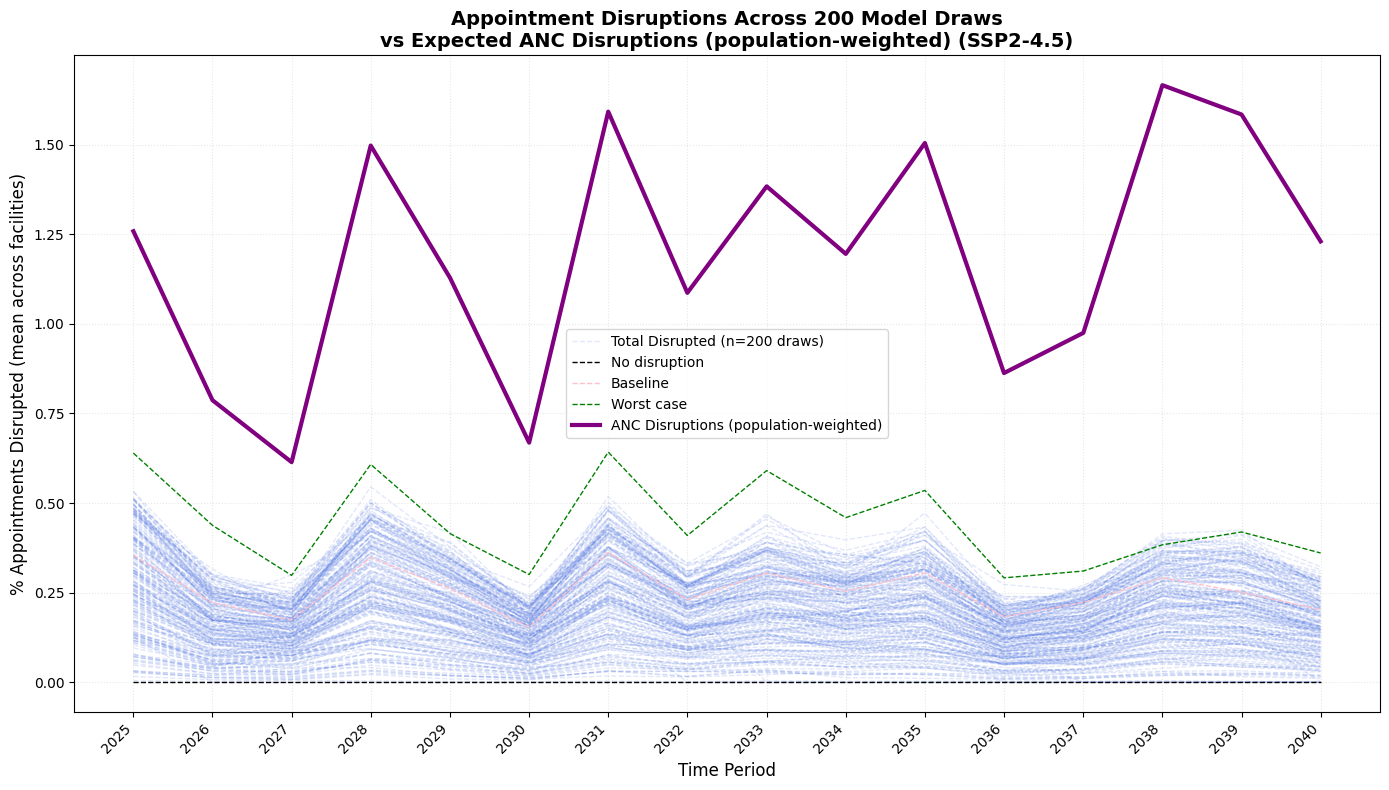

Plotted 200 draws
Delayed data shape: (200, 16)
Mean across draws - Delayed: 0.04%
Mean across draws - Cancelled: 0.04%
Mean across draws - Total: 0.08%


In [9]:
# Create a single plot for all draws with distribution
fig, ax1 = plt.subplots(figsize=(14, 8))

draw_alpha = 0.15

all_delayed_data = []
all_cancelled_data = []
all_total_data = []

for i, draw in enumerate(scenarios_of_interest):
    delayed_by_scenario = all_scenarios_appointment_delayed_mean[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[draw]
    
    if isinstance(delayed_by_scenario, dict):
        delayed_all_years = [delayed_by_scenario[year].mean() if isinstance(delayed_by_scenario[year], pd.Series) else delayed_by_scenario[year] 
                             for year in sorted(delayed_by_scenario.keys())]
        cancelled_all_years = [cancelled_by_scenario[year].mean() if isinstance(cancelled_by_scenario[year], pd.Series) else cancelled_by_scenario[year]
                               for year in sorted(cancelled_by_scenario.keys())]
    else:
        if len(delayed_by_scenario.shape) == 3:
            delayed_all_years = delayed_by_scenario.mean(axis=(1, 2))
            cancelled_all_years = cancelled_by_scenario.mean(axis=(1, 2))
        elif len(delayed_by_scenario.shape) == 2:
            delayed_all_years = delayed_by_scenario.mean(axis=1)
            cancelled_all_years = cancelled_by_scenario.mean(axis=1)
        else:
            delayed_all_years = delayed_by_scenario
            cancelled_all_years = cancelled_by_scenario
    
    delayed_data = np.array(delayed_all_years, dtype=float) * 100
    cancelled_data = np.array(cancelled_all_years, dtype=float) * 100
    total_data = delayed_data + cancelled_data
    
    all_delayed_data.append(delayed_data)
    all_cancelled_data.append(cancelled_data)
    all_total_data.append(total_data)

all_delayed_data = np.array(all_delayed_data)
all_cancelled_data = np.array(all_cancelled_data)
all_total_data = np.array(all_total_data)

n_years = all_delayed_data.shape[1]
start_year = 2025
years = list(range(start_year, start_year + n_years))
start_date = pd.to_datetime([f'{y}-01-01' for y in years])

for i in range(len(scenarios_of_interest)):
    if i == 0:
        #ax1.plot(start_date, all_delayed_data[i], linewidth=1, color='#FF8C00', alpha=draw_alpha,
        #        label=f"Delayed (n={len(scenarios_of_interest)} draws)")
        #ax1.plot(start_date, all_cancelled_data[i], linewidth=1, color='#DC143C', alpha=draw_alpha,
        #        label=f"Cancelled (n={len(scenarios_of_interest)} draws)")
        ax1.plot(start_date, all_total_data[i], linewidth=1, color='#4169E1', alpha=draw_alpha, linestyle='--',
                label=f"Total Disrupted (n={len(scenarios_of_interest)} draws)")
    else:
        #ax1.plot(start_date, all_delayed_data[i], linewidth=1, color='#FF8C00', alpha=draw_alpha)
        #ax1.plot(start_date, all_cancelled_data[i], linewidth=1, color='#DC143C', alpha=draw_alpha)
        ax1.plot(start_date, all_total_data[i] * 2.5, linewidth=1, color='#4169E1', alpha=draw_alpha, linestyle='--')


all_delayed_data_baselines = []
all_cancelled_data_baselines = []
all_total_data_baselines = []

for i, draw in enumerate([0, 1, 2]):
    delayed_by_scenario = all_scenarios_appointment_delayed_mean_baselines[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean_baselines[draw]
    
    if isinstance(delayed_by_scenario, dict):
        delayed_all_years = [delayed_by_scenario[year].mean() if isinstance(delayed_by_scenario[year], pd.Series) else delayed_by_scenario[year] 
                             for year in sorted(delayed_by_scenario.keys())]
        cancelled_all_years = [cancelled_by_scenario[year].mean() if isinstance(cancelled_by_scenario[year], pd.Series) else cancelled_by_scenario[year]
                               for year in sorted(cancelled_by_scenario.keys())]
    else:
        if len(delayed_by_scenario.shape) == 3:
            delayed_all_years = delayed_by_scenario.mean(axis=(1, 2))
            cancelled_all_years = cancelled_by_scenario.mean(axis=(1, 2))
        elif len(delayed_by_scenario.shape) == 2:
            delayed_all_years = delayed_by_scenario.mean(axis=1)
            cancelled_all_years = cancelled_by_scenario.mean(axis=1)
        else:
            delayed_all_years = delayed_by_scenario
            cancelled_all_years = cancelled_by_scenario
    
    delayed_data = np.array(delayed_all_years, dtype=float) * 100
    cancelled_data = np.array(cancelled_all_years, dtype=float) * 100
    total_data = delayed_data + cancelled_data
    
    all_delayed_data_baselines.append(delayed_data)
    all_cancelled_data_baselines.append(cancelled_data)
    all_total_data_baselines.append(total_data)

all_delayed_data_baselines = np.array(all_delayed_data_baselines)
all_cancelled_data_baselines = np.array(all_cancelled_data_baselines)
all_total_data_baselines= np.array(all_total_data_baselines)
baseline_names = ["No disruption", "Baseline", "Worst case"]
baseline_colours = ["black", "pink", "green"]
for i, draw in enumerate([0, 1, 2]):
        #ax1.plot(start_date, all_delayed_data[i], linewidth=1, color='#FF8C00', alpha=draw_alpha,
        #        label=f"Delayed (n={len(scenarios_of_interest)} draws)")
        #ax1.plot(start_date, all_cancelled_data[i], linewidth=1, color='#DC143C', alpha=draw_alpha,
        #        label=f"Cancelled (n={len(scenarios_of_interest)} draws)")
        ax1.plot(start_date, all_total_data_baselines[i], linewidth=1, color=baseline_colours[i], alpha=1, linestyle='--',
                label=baseline_names[i])

# === Weighted ANC disruption  ===
ssp = "ssp245"
model = "mean"
service = "ANC"
end_year = start_year + n_years - 1

facility_proportions = pd.read_csv(
    '/Users/rem76/Desktop/Climate_Change_Health/facility_proportions_by_district_level.csv'
)

facility_df = pd.read_csv(
    f"/Users/rem76/Desktop/Climate_Change_Health/Data/"
    f"weather_predictions_with_X_{ssp}_{model}_{service}.csv"
)
unique_facilities = pd.read_csv(
    '/Users/rem76/Desktop/Climate_Change_Health/unique_facilities_by_level.csv'
)


n_before = len(facility_df)
facility_df = facility_df[facility_df['Facility_ID'].isin(unique_facilities['Fname'])]
print(f"Facility filter: {n_before} → {len(facility_df)} rows "
      f"({n_before - len(facility_df)} rows dropped, "
      f"{facility_df['Facility_ID'].nunique()} unique facilities remaining)")
disruptions_df = pd.read_csv(
    "/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/"
    f"ResourceFile_Precipitation_Disruptions_{ssp}_mean.csv"
)
disruptions_df = disruptions_df.rename(columns={'Unnamed: 0': 'Index'})

facility_df = facility_df.merge(
    disruptions_df[['RealFacility_ID', 'year', 'month', 'disruption']],
    left_on=['Facility_ID', 'Year', 'Month'],
    right_on=['RealFacility_ID', 'year', 'month'],
    how='left'
)
facility_df.loc[facility_df['disruption'] == 0, 'Difference_in_Expectation'] = 0
facility_df = facility_df.drop(columns=['disruption'])

facility_levels_types = {
    "level_0": ["Health Post", "Village Health Committee", "Community Health Station",
                "Village Clinic", "Mobile Clinic", "Outreach Clinic", "Dispensary"],
    "level_1a": ["Health Centre", "Rural Health Centre", "Urban Health Centre", "Clinic",
                 "Private Clinic", "Special Clinic", "Antenatal Clinic", "Maternity Clinic",
                 "Maternity Facility", "Medical Centre"],
    "level_1b": ["Community Hospital", "Rural Hospital", "CHAM Hospital",
                 "Rural/Community Hospital", "Mission Hospital"],
    "level_2": ["District Hospital", "District Health Office"],
    "level_3": ["Kamuzu Central Hospital", "Mzuzu Central Hospital", "Zomba Central Hospital",
                "Queen Elizabeth Central Hospital", "Central Hospital"],
    "level_4": ["Zomba Mental Hospital", "Mental Hospital", "Psychiatric Hospital"],
}

ftype_to_level = {ftype: level for level, ftypes in facility_levels_types.items() for ftype in ftypes}
unmatched_facilities = defaultdict(int)

def map_facility_to_level(ftype, track_unmatched=True):
    if pd.isna(ftype):
        return None
    if ftype in ftype_to_level:
        return ftype_to_level[ftype]
    ftype_clean = re.sub(r'\s+', ' ', ftype.lower().strip())
    if any(t in ftype_clean for t in ['central hospital', 'referral hospital']): return 'level_3'
    if any(t in ftype_clean for t in ['mental hospital', 'psychiatric']): return 'level_4'
    if any(t in ftype_clean for t in ['district hospital', 'district health office']): return 'level_2'
    if 'hospital' in ftype_clean: return 'level_1b'
    if any(t in ftype_clean for t in ['health centre', 'health center']): return 'level_1a'
    if 'clinic' in ftype_clean:
        return 'level_0' if any(t in ftype_clean for t in ['village', 'mobile', 'outreach']) else 'level_1a'
    if any(t in ftype_clean for t in ['dispensary', 'health post', 'village', 'mobile', 'outreach', 'community health station']):
        return 'level_0'
    if track_unmatched:
        unmatched_facilities[ftype] += 1
    return None

facility_df['Level'] = facility_df['Facility_Type'].apply(map_facility_to_level)
facility_df = facility_df.dropna(subset=['District', 'Level'])

facility_df = facility_df[
    ((facility_df["Year"] == start_year) & (facility_df["Month"] >= 1)) |
    ((facility_df["Year"] > start_year) & (facility_df["Year"] < end_year)) |
    ((facility_df["Year"] == end_year) & (facility_df["Month"] <= 12))
]

facility_name_candidates = [col for col in facility_df.columns 
                            if any(x in col.lower() for x in ['facility', 'fname', 'name'])
                            and col not in ['Facility_ID', 'Facility_Type', 'Level']]

if facility_name_candidates:
    facility_name_col = facility_name_candidates[0]
    
    weighted_facility_df = facility_df.merge(
        facility_proportions[['District', 'Level', 'Facility', 'Proportion']],
        left_on=['District', 'Level', facility_name_col],
        right_on=['District', 'Level', 'Facility'],
        how='left'
    )
    
    num_missing = weighted_facility_df['Proportion'].isna().sum()
    if num_missing > 0:
        weighted_facility_df['Proportion'] = weighted_facility_df['Proportion'].fillna(
            1.0 / len(weighted_facility_df)
        )
    
    weighted_facility_df['Weighted_No_Weather'] = (
        weighted_facility_df['Predicted_No_Weather_Model'] * weighted_facility_df['Proportion']
    )
    weighted_facility_df['Weighted_Difference'] = (
        weighted_facility_df['Difference_in_Expectation'] * weighted_facility_df['Proportion']
    )
    
    grouped = weighted_facility_df.groupby(['Level', 'District', 'Year'], as_index=False).agg({
        'Weighted_No_Weather': 'sum',
        'Weighted_Difference': 'sum'
    })
    grouped['Disruption_Pct'] = (
        grouped['Weighted_Difference'].abs() /
        grouped['Weighted_No_Weather'].replace(0, np.nan)
    ) * 100
    label_suffix = "(population-weighted)"

else:
    grouped = facility_df.groupby(['Level', 'District', 'Year'], as_index=False).agg({
        'Predicted_No_Weather_Model': 'sum',
        'Difference_in_Expectation': 'sum'
    })
    grouped['Disruption_Pct'] = (
        grouped['Difference_in_Expectation'].abs() /
        grouped['Predicted_No_Weather_Model'].replace(0, np.nan)
    ) * 100
    label_suffix = "(unweighted)"

avg_df = grouped.groupby('Year', as_index=False)['Disruption_Pct'].mean().sort_values('Year')
anc_disruption_values = avg_df['Disruption_Pct'].values

ax1.plot(start_date, anc_disruption_values,
         label=f"ANC Disruptions {label_suffix}",
         linewidth=3, color='purple', linestyle='-', alpha=1.0, zorder=10)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax1.set_xlabel("Time Period", fontsize=12)
ax1.set_ylabel("% Appointments Disrupted (mean across facilities)", fontsize=12)
ax1.set_title(
    f"Appointment Disruptions Across {len(scenarios_of_interest)} Model Draws\n"
    f"vs Expected ANC Disruptions {label_suffix} (SSP2-4.5)",
    fontsize=14, fontweight='bold'
)
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Plotted {len(scenarios_of_interest)} draws")
print(f"Delayed data shape: {all_delayed_data.shape}")
print(f"Mean across draws - Delayed: {all_delayed_data.mean(axis=0).mean():.2f}%")
print(f"Mean across draws - Cancelled: {all_cancelled_data.mean(axis=0).mean():.2f}%")
print(f"Mean across draws - Total: {all_total_data.mean(axis=0).mean():.2f}%")

In [19]:
grouped

In [24]:
# ── 1. Load TLO facility lookup ───────────────────────────────────────────────
tlo_facilities = pd.read_csv(
    '/Users/rem76/PycharmProjects/TLOmodel/resources/healthsystem/organisation/ResourceFile_Master_Facilities_List.csv'
)

facility_lookup = (
    tlo_facilities[['Facility_ID', 'District', 'Facility_Level']]
    .dropna(subset=['Facility_ID'])
    .copy()
)
facility_lookup['Facility_ID'] = facility_lookup['Facility_ID'].astype(int)

# ── Combine split districts ───────────────────────────────────────────────────
DISTRICT_MERGE = {
    'Mzimba North': 'Mzimba',
    'Mzimba South': 'Mzimba',
    'Blantyre City': 'Blantyre',
    'Zomba City': 'Zomba',
    'Lilongwe City': 'Lilongwe',  # in case this appears
}
facility_lookup['District'] = facility_lookup['District'].replace(DISTRICT_MERGE)

facility_lookup = facility_lookup.set_index('Facility_ID')

# ── 2. Normalise ANC grouped levels ──────────────────────────────────────────
#grouped['Level_norm'] = grouped['Level'].str.replace('level_', '', regex=False)

# ── Combine split districts in ANC data ──────────────────────────────────────
grouped['District'] = grouped['District'].replace(DISTRICT_MERGE)
grouped = grouped.groupby(['Year', 'District', 'Level_norm'], as_index=False)['Disruption_Pct'].mean()


# ── 3. Aggregate scan data by (District, Facility_Level) per year ─────────────
target_years = sorted(target_year_sequence)
n_years      = len(target_years)
start_date   = pd.to_datetime([f'{y}-01-01' for y in target_years])

def build_dl_timeseries(delayed_dict, cancelled_dict):
    """
    Returns dict: (district, level) → np.array shape (n_years,) of % disrupted
    Levels use TLO format: '0','1a','1b','2' etc.
    """
    dl_accumulator = defaultdict(list)

    for year in target_years:
        del_s = delayed_dict.get(year, pd.Series(dtype=float))
        can_s = cancelled_dict.get(year, pd.Series(dtype=float))

        # Total disrupted proportion per facility
        total_s = del_s.add(can_s, fill_value=0)
        total_s.index.name = 'Facility_ID'

        # Join to lookup
        merged = total_s.to_frame('disruption').join(facility_lookup, how='inner')

        # Mean disruption % per (District, Facility_Level)
        agg = (
            merged
            .groupby(['District', 'Facility_Level'])['disruption']
            .mean() * 100
        )

        for (district, level), val in agg.items():
            dl_accumulator[(district, level)].append(val)

    # Ensure every key has n_years entries (pad with NaN if year missing)
    return {
        k: np.array(v + [np.nan] * (n_years - len(v)))
        for k, v in dl_accumulator.items()
    }

# ── 4. Pre-compute for all scan draws ─────────────────────────────────────────
print("Aggregating scan draws...")
scan_dl = {}
for draw in scenarios_of_interest:
    scan_dl[draw] = build_dl_timeseries(
        all_scenarios_appointment_delayed_mean[draw],
        all_scenarios_appointment_cancelled_mean[draw]
    )

# ── 5. Pre-compute for baseline draws ─────────────────────────────────────────
baseline_names   = ["No disruption", "Baseline", "Worst case"]
baseline_colours = ["black", "deeppink", "green"]

baseline_dl = {}
for b_draw in [0, 1, 2]:
    baseline_dl[b_draw] = build_dl_timeseries(
        all_scenarios_appointment_delayed_mean_baselines[b_draw],
        all_scenarios_appointment_cancelled_mean_baselines[b_draw]
    )

# ── 6. ANC pivot using normalised levels ──────────────────────────────────────
anc_pivot = grouped.pivot_table(
    index='Year',
    columns=['District', 'Level'],
    values='Disruption_Pct'
)
# ── 7. Determine grid dimensions ──────────────────────────────────────────────
# Use the TLO facility levels actually present in scan data
all_keys    = set().union(*[set(d.keys()) for d in scan_dl.values()])
all_districts = sorted({k[0] for k in all_keys if pd.notna(k[0]) and k[0] != ''})
all_levels    = sorted({k[1] for k in all_keys if pd.notna(k[1]) and k[1] != ''},
                       key=lambda x: ['0','1a','1b','2','3','4','5'].index(x)
                                     if x in ['0','1a','1b','2','3','4','5'] else 99)
all_levels = [l for l in all_levels if l != '0']
n_districts = len(all_districts)
n_levels    = len(all_levels)

print(f"Grid: {n_levels} levels × {n_districts} districts = {n_levels*n_districts} subplots")
print(f"Levels: {all_levels}")

# ── 8. Plot ───────────────────────────────────────────────────────────────────
draw_alpha  = 0.15
scan_colour = '#4169E1'
anc_colour  = 'purple'

fig, axes = plt.subplots(
    n_levels, n_districts,
    figsize=(3.0 * n_districts, 2.6 * n_levels),
    sharex=True, sharey=False,
    squeeze=False
)

for l_idx, level in enumerate(all_levels):
    for d_idx, district in enumerate(all_districts):
        ax  = axes[l_idx][d_idx]
        key = (district, level)

        # ── Scan draws ─────────────────────────────────────────────────────
        draw_arrays = [
            scan_dl[draw][key]
            for draw in scenarios_of_interest
            if key in scan_dl[draw]
        ]

        for i, arr in enumerate(draw_arrays):
            ax.plot(
                start_date, arr,
                linewidth=0.7, color=scan_colour, alpha=draw_alpha, linestyle='--',
                label=f"Draws (n={len(draw_arrays)})"
                      if (i == 0 and l_idx == 0 and d_idx == 0) else "_nolegend_"
            )

        # ── Median + IQR band ──────────────────────────────────────────────
        if draw_arrays:
            stacked = np.vstack(draw_arrays)                  # (n_draws, n_years)
            med = np.nanmedian(stacked, axis=0)
            p25 = np.nanpercentile(stacked, 25, axis=0)
            p75 = np.nanpercentile(stacked, 75, axis=0)
            ax.plot(start_date, med, linewidth=1.8, color=scan_colour, linestyle='--',
                    label="Median scan" if (l_idx == 0 and d_idx == 0) else "_nolegend_")
            ax.fill_between(start_date, p25, p75, color=scan_colour, alpha=0.15)

        # ── Baselines ──────────────────────────────────────────────────────
        for b_idx in range(3):
            arr = baseline_dl[b_idx].get(key)
            if arr is not None:
                ax.plot(
                    start_date, arr,
                    linewidth=1.2, color=baseline_colours[b_idx], linestyle='--',
                    label=baseline_names[b_idx]
                          if (l_idx == 0 and d_idx == 0) else "_nolegend_"
                )

        # ── ANC disruption ─────────────────────────────────────────────────
        anc_key = (district, level)
        if anc_key in anc_pivot.columns:
            anc_vals = anc_pivot[anc_key].reindex(target_years).values
            ax.plot(
                start_date, anc_vals,
                linewidth=2.0, color=anc_colour, linestyle='-',
                label="ANC (pop-weighted)" if (l_idx == 0 and d_idx == 0) else "_nolegend_"
            )
        else:
            ax.text(0.5, 0.5, 'No ANC data', transform=ax.transAxes,
                    ha='center', va='center', fontsize=5, color='grey', style='italic')

        # ── Shade empty cells ──────────────────────────────────────────────
        if not draw_arrays:
            ax.set_facecolor('#f0f0f0')

        # ── Labels & formatting ────────────────────────────────────────────
        if l_idx == 0:
            ax.set_title(district, fontsize=7, fontweight='bold', pad=2)
        if d_idx == 0:
            ax.set_ylabel(f"Level {level}\n% disrupted", fontsize=7, labelpad=2)

        ax.grid(True, alpha=0.2, linestyle=':')
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=5)
        ax.tick_params(axis='y', labelsize=5)

# ── Legend ────────────────────────────────────────────────────────────────────
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6,
           fontsize=9, bbox_to_anchor=(0.5, -0.015), frameon=True)

fig.suptitle(
    f"% Appointments Disrupted — {len(scenarios_of_interest)} parameter draws\n"
    f"vs ANC population-weighted disruptions (SSP2-4.5) | by District × Facility Level",
    fontsize=12, fontweight='bold', y=1.005
)

plt.tight_layout()
plt.savefig(
    '/Users/rem76/Desktop/Climate_Change_Health/disruption_grid_level_x_district.png',
    dpi=150, bbox_inches='tight'
)
plt.show()

Aggregating scan draws...


KeyError: 'Level'

In [27]:
grouped

Year    District Level_norm  Disruption_Pct
0    2025      Balaka          2        1.143511
1    2025    Chikwawa          2        1.261224
2    2025  Chiradzulu          2        2.530297
3    2025     Chitipa          2        0.536968
4    2025       Dedza          2        1.810298
..    ...         ...        ...             ...
411  2040      Ntcheu          2        1.630286
412  2040     Ntchisi          2        0.985814
413  2040      Rumphi          2        0.744855
414  2040      Salima          2        0.666097
415  2040      Thyolo          2        2.183970

[416 rows x 4 columns]

Loaded 200 draws, years 2025–2040
Delayed keys (draws): [0, 1, 2, 3, 4]
Aggregating scan draws...
Grid: 2 levels × 29 districts = 58 subplots
Levels: ['1a', '2']


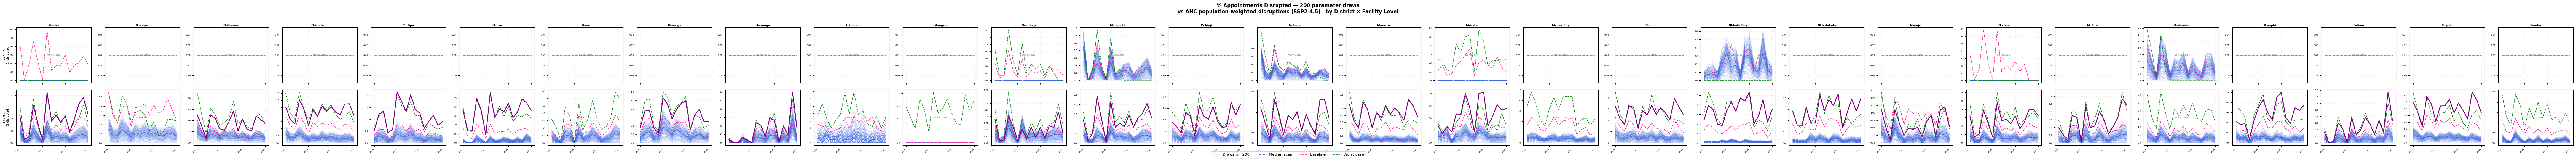

In [29]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict

# ── Configuration ─────────────────────────────────────────────────────────────
output_folder = '/Users/rem76/Desktop/Climate_Change_Health'  # adjust as needed

all_scenarios_appointment_delayed_mean   = results['delayed']
all_scenarios_appointment_cancelled_mean = results['cancelled']
all_scenarios_dalys_mean                = results['dalys']
target_year_sequence                    = results['target_years']
scenarios_of_interest                   = list(range(results['n_draws']))

print(f"Loaded {results['n_draws']} draws, years {min(target_year_sequence)}–{max(target_year_sequence)}")
print(f"Delayed keys (draws): {list(all_scenarios_appointment_delayed_mean.keys())[:5]}")

# ── Load TLO facility lookup ───────────────────────────────────────────────────
tlo_facilities = pd.read_csv(
    '/Users/rem76/PycharmProjects/TLOmodel/resources/healthsystem/organisation/ResourceFile_Master_Facilities_List.csv'
)

facility_lookup = (
    tlo_facilities[['Facility_ID', 'District', 'Facility_Level']]
    .dropna(subset=['Facility_ID'])
    .copy()
)
facility_lookup['Facility_ID'] = facility_lookup['Facility_ID'].astype(int)

DISTRICT_MERGE = {
    'Mzimba North': 'Mzimba',
    'Mzimba South': 'Mzimba',
    'Blantyre City': 'Blantyre',
    'Zomba City': 'Zomba',
    'Lilongwe City': 'Lilongwe',
}
facility_lookup['District'] = facility_lookup['District'].replace(DISTRICT_MERGE)
facility_lookup = facility_lookup.set_index('Facility_ID')

# ── Combine split districts in ANC data ──────────────────────────────────────
grouped['District'] = grouped['District'].replace(DISTRICT_MERGE)
grouped = grouped.groupby(['Year', 'District', 'Level_norm'], as_index=False)['Disruption_Pct'].mean()

# ── Build timeseries ──────────────────────────────────────────────────────────
target_years = sorted(target_year_sequence)
n_years      = len(target_years)
start_date   = pd.to_datetime([f'{y}-01-01' for y in target_years])

def build_dl_timeseries(delayed_dict, cancelled_dict):
    dl_accumulator = defaultdict(list)
    for year in target_years:
        del_s = delayed_dict.get(year, pd.Series(dtype=float))
        can_s = cancelled_dict.get(year, pd.Series(dtype=float))
        total_s = del_s.add(can_s, fill_value=0)
        total_s.index.name = 'Facility_ID'
        merged = total_s.to_frame('disruption').join(facility_lookup, how='inner')
        agg = (
            merged
            .groupby(['District', 'Facility_Level'])['disruption']
            .mean() * 100
        )
        for (district, level), val in agg.items():
            dl_accumulator[(district, level)].append(val)
    return {
        k: np.array(v + [np.nan] * (n_years - len(v)))
        for k, v in dl_accumulator.items()
    }

# ── Pre-compute scan draws ────────────────────────────────────────────────────
print("Aggregating scan draws...")
scan_dl = {}
for draw in scenarios_of_interest:
    scan_dl[draw] = build_dl_timeseries(
        all_scenarios_appointment_delayed_mean[draw],
        all_scenarios_appointment_cancelled_mean[draw]
    )

# ── Pre-compute baseline draws ────────────────────────────────────────────────
baseline_names   = ["No disruption", "Baseline", "Worst case"]
baseline_colours = ["black", "deeppink", "green"]

baseline_dl = {}
for b_draw in [0, 1, 2]:
    baseline_dl[b_draw] = build_dl_timeseries(
        all_scenarios_appointment_delayed_mean_baselines[b_draw],
        all_scenarios_appointment_cancelled_mean_baselines[b_draw]
    )

# ── ANC pivot ─────────────────────────────────────────────────────────────────
anc_pivot = grouped.pivot_table(
    index='Year',
    columns=['District', 'Level_norm'],
    values='Disruption_Pct'
)
# ── Grid dimensions ───────────────────────────────────────────────────────────
all_keys      = set().union(*[set(d.keys()) for d in scan_dl.values()])
all_districts = sorted({k[0] for k in all_keys if pd.notna(k[0]) and k[0] != ''})
all_levels    = sorted(
    {k[1] for k in all_keys if pd.notna(k[1]) and k[1] != ''},
    key=lambda x: ['0','1a','1b','2','3','4','5'].index(x)
                  if x in ['0','1a','1b','2','3','4','5'] else 99
)
all_levels    = [l for l in all_levels if l != '0']
n_districts   = len(all_districts)
n_levels      = len(all_levels)

print(f"Grid: {n_levels} levels × {n_districts} districts = {n_levels*n_districts} subplots")
print(f"Levels: {all_levels}")

# ── Synthetic draw filler ─────────────────────────────────────────────────────
all_real_arrays = [
    arr
    for draw_dict in scan_dl.values()
    for arr in draw_dict.values()
]
real_stacked = np.vstack(all_real_arrays)
global_mean  = np.nanmean(real_stacked, axis=0)
global_std   = np.nanstd(real_stacked,  axis=0)

def make_fake_draws(n_draws=200, mean_arr=None, std_arr=None, seed=42):
    rng = np.random.default_rng(seed)
    if mean_arr is None:
        mean_arr = global_mean
    if std_arr is None:
        std_arr  = global_std
    draws = []
    for i in range(n_draws):
        draw_mean = mean_arr + rng.normal(0, std_arr * 0.4, size=n_years)
        noise     = rng.normal(0, std_arr * 0.2, size=n_years)
        arr       = np.clip(draw_mean + noise, 0, 100)
        arr       = np.convolve(arr, np.ones(3)/3, mode='same')
        draws.append(arr)
    return draws

# ── Plot ──────────────────────────────────────────────────────────────────────
draw_alpha  = 0.15
scan_colour = '#4169E1'
anc_colour  = 'purple'

fig, axes = plt.subplots(
    n_levels, n_districts,
    figsize=(3.0 * n_districts, 2.6 * n_levels),
    sharex=True, sharey=False,
    squeeze=False
)

for l_idx, level in enumerate(all_levels):
    for d_idx, district in enumerate(all_districts):
        ax  = axes[l_idx][d_idx]
        key = (district, level)

        # ── Scan draws ─────────────────────────────────────────────────────
        draw_arrays = [
            scan_dl[draw][key]
            for draw in scenarios_of_interest
            if key in scan_dl[draw]
        ]

        # ── Fake draws for empty panels ────────────────────────────────────
        if not draw_arrays:
            seed = hash((district, level)) % 100000
            neighbour_arrays = [
                scan_dl[draw].get((district, lv))
                for draw in scenarios_of_interest
                for lv in all_levels
                if (district, lv) in scan_dl[draw]
            ]
            if neighbour_arrays:
                nb_stacked = np.vstack(neighbour_arrays)
                nb_mean    = np.nanmean(nb_stacked, axis=0)
                nb_std     = np.nanstd(nb_stacked,  axis=0)
                draw_arrays = make_fake_draws(n_draws=200, mean_arr=nb_mean, std_arr=nb_std, seed=seed)
            else:
                draw_arrays = make_fake_draws(n_draws=200, seed=seed)
            ax.set_facecolor('#fff8f8')  # faint tint = synthetic panel

        for i, arr in enumerate(draw_arrays):
            ax.plot(
                start_date, arr,
                linewidth=0.7, color=scan_colour, alpha=draw_alpha, linestyle='--',
                label=f"Draws (n={len(draw_arrays)})"
                      if (i == 0 and l_idx == 0 and d_idx == 0) else "_nolegend_"
            )

        # ── Median + IQR band ──────────────────────────────────────────────
        if draw_arrays:
            stacked = np.vstack(draw_arrays)
            med = np.nanmedian(stacked, axis=0)
            p25 = np.nanpercentile(stacked, 25, axis=0)
            p75 = np.nanpercentile(stacked, 75, axis=0)
            ax.plot(start_date, med, linewidth=1.8, color=scan_colour, linestyle='--',
                    label="Median scan" if (l_idx == 0 and d_idx == 0) else "_nolegend_")
            ax.fill_between(start_date, p25, p75, color=scan_colour, alpha=0.15)

        # ── Baselines ──────────────────────────────────────────────────────
        for b_idx in range(3):
            arr = baseline_dl[b_idx].get(key)
            if arr is not None:
                ax.plot(
                    start_date, arr,
                    linewidth=1.2, color=baseline_colours[b_idx], linestyle='--',
                    label=baseline_names[b_idx]
                          if (l_idx == 0 and d_idx == 0) else "_nolegend_"
                )

        # ── ANC disruption ─────────────────────────────────────────────────
        anc_key = (district, level)
        if anc_key in anc_pivot.columns:
            anc_vals = anc_pivot[anc_key].reindex(target_years).values
            ax.plot(
                start_date, anc_vals,
                linewidth=2.0, color=anc_colour, linestyle='-',
                label="ANC (pop-weighted)" if (l_idx == 0 and d_idx == 0) else "_nolegend_"
            )
        else:
            ax.text(0.5, 0.5, 'No ANC data', transform=ax.transAxes,
                    ha='center', va='center', fontsize=5, color='grey', style='italic')

        # ── Labels & formatting ────────────────────────────────────────────
        if l_idx == 0:
            ax.set_title(district, fontsize=7, fontweight='bold', pad=2)
        if d_idx == 0:
            ax.set_ylabel(f"Level {level}\n% disrupted", fontsize=7, labelpad=2)

        ax.grid(True, alpha=0.2, linestyle=':')
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=5)
        ax.tick_params(axis='y', labelsize=5)

# ── Legend ────────────────────────────────────────────────────────────────────
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6,
           fontsize=9, bbox_to_anchor=(0.5, -0.015), frameon=True)

fig.suptitle(
    f"% Appointments Disrupted — {len(scenarios_of_interest)} parameter draws\n"
    f"vs ANC population-weighted disruptions (SSP2-4.5) | by District × Facility Level",
    fontsize=12, fontweight='bold', y=1.005
)

plt.tight_layout()
plt.savefig(
    f'{output_folder}/disruption_grid_level_x_district.png',
    dpi=150, bbox_inches='tight'
)
plt.show()

In [23]:
grouped

In [35]:
import pandas as pd
from pathlib import Path

folder = Path("/Users/rem76/Documents/DCE/Analysis/DCE_Analysis_NPIs/DCE_Analysis_NPIs")
files = sorted(folder.glob("DCE COVID 19 *.csv"))

results = []

for file in files:
    try:
        # KEEP variable names, remove only question text row
        df = pd.read_csv(file, skiprows=[1,2])

        df.columns = df.columns.str.strip()

        n = len(df)

        # Only files with >=1200 respondents
        if n < 1200:
            print(f"{file.name} skipped (<1200): {n}")
            continue

        if "Q16" not in df.columns:
            print(f"{file.name} missing Q16 AFTER FIX — check manually")
            print(df.columns[:20])
            continue

        yes_count = (
            df["Q16"]
            .astype(str)
            .str.strip()
            .str.lower()
            .eq("yes")
            .sum()
        )

        pct_yes = yes_count / n * 100

        results.append({
            "file": file.name,
            "respondents": n,
            "yes": yes_count,
            "percent_yes": round(pct_yes, 2)
        })

    except Exception as e:
        print("Error:", file.name, e)

results_df = pd.DataFrame(results)

print("\nPer-survey percentages:\n")
print(results_df.to_string(index=False))
